In [1]:
## ######################################################################### ##
## Analysis of IMDB Movie Dataset
## For EdX Course
## Python for Data Science (Week 6 Mini Project)
## ######################################################################### ##

## ========================================================================= ## 
## import libraries
## ========================================================================= ##

import requests
import io
import zipfile
import os
import urllib.parse
import re   ## for regular expressions
from itertools import chain  ## for chain, similar to R's unlist
import collections   ## for Counters (used in frequency tables, for example)
import numpy as np
import pandas as pd
from plotnine import *
import matplotlib.pyplot as plt


## ========================================================================= ##
## download and extract zip
## ========================================================================= ##

## define url and filename, as well as target path:
url_base = 'http://files.grouplens.org/datasets/movielens/'
filename = 'ml-20m.zip'
url = urllib.parse.urljoin(url_base, filename)
path_dat = './data'

# ## download (commented out in order not to repeat it every time):
# r = requests.get(url, allow_redirects=True)
# open(filename, 'wb').write(r.content)
#
# ## check download:
# os.getcwd()
# os.listdir()
# 
# ## unzip:
# zip_ref = zipfile.ZipFile(filename, 'r')
# zip_ref.extractall(path_dat)
# zip_ref.close()

## ========================================================================= ##
## Load data files
## ========================================================================= ##

dat_movies = pd.read_csv(
    os.path.join(path_dat, 'ml-20m/movies.csv'), 
    sep = ',')

dat_movies.head(2)
dat_movies.info()

#dat_movies.dtype                    ## 'DataFrame' object has no attribute 'dtype'
dat_movies['movieId'].dtype
dat_movies['title'].dtype   

type(dat_movies)                     ## also for DataFrame: pandas.core.frame.DataFrame
type(dat_movies['movieId'])          ## pandas.core.series.Series
type(dat_movies['movieId'].values)   ## numpy.ndarray
type(dat_movies['movieId'][1])       ## numpy.int64

dir(dat_movies)                      ## list all methods?

## find strings in this list:
# dir(dat_movies).str.contains('unstack')  ... str.-methods only work on pandas df, not lists
list(filter(lambda x:'values' in x, dir(dat_movies)))  ## filter returns an iterable, hence need 'list'
list(filter(lambda x: re.search(r'unstack', x), dir(dat_movies)))

#cond = df['A'].str.contains('a')

dat_movies.__dict__                  ## lengthy, equivalent to vars(<>)
vars(dat_movies)                     ## lengthy, equivalent to <>.__dict__

## get column names:
list(dat_movies.columns.values)      
list(dat_movies)                     ## same

## summary of data frame
dat_movies.describe()                ## similar to R's summary()

dat_ratings = pd.read_csv(
    os.path.join(path_dat, 'ml-20m/ratings.csv'), 
    sep = ',')

dat_ratings.head(2)
dat_ratings.info()

dat_tags = pd.read_csv(
    os.path.join(path_dat, 'ml-20m/tags.csv'), 
    sep = ',')

dat_tags.head(2)
dat_tags.info()

## Note:
## For some reason, string columns are of type "object".
## https://stackoverflow.com/questions/33957720/how-to-convert-column-with-dtype-as-object-to-string-in-pandas-dataframe
## since strings data types have variable length, 
## it is by default stored as object dtype. If you want to store them as 
## string type, you can do something like this.
## df['column'] = df['column'].astype('|S80') #where the max length is set at 80 bytes,
## or alternatively
## df['column'] = df['column'].astype('|S') # which will by default set the length to the max len it encounters
##  the pandas dataframe stores the pointers to the strings and hence it is of type 'object'.

#dat_movies.head(2)['title'].astype('str')

## ========================================================================= ##
## data prep
## ========================================================================= ##

## possible research questions:
## * what is the relationship of movie complexity 
##   (as measured by number of genres) and average rating? u-shaped?
## * what is the relationship of genres and average rating? 
##   have different genres different ratings, on average?


## ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ##
## aggregate ratings data
## ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ##

## aggregate ratings data:
## https://stackoverflow.com/questions/38935541/dplyr-summarize-equivalent-in-pandas
dat_ratings_agg = dat_ratings \
    .groupby('movieId') \
    .agg({'rating': ['size', 'min', 'max', 'mean', 'std'], 
         'timestamp': ['min', 'max', 'mean', 'std']})
#dat_ratings_agg.head(2)

## rename columns:
dat_ratings_agg.columns = ['_'.join(col) \
                           for col in dat_ratings_agg.columns]
#dat_ratings_agg.head(2)

## add correct timestamp column (after aggregation, 
## as they cannot be aggregated like numerical values):
dat_tags['parsed_time'] = pd.to_datetime(
    dat_tags['timestamp'], unit='s')
dat_ratings['parsed_time'] = pd.to_datetime(
    dat_ratings['timestamp'], unit='s')
dat_ratings_agg['parsed_time_min'] = pd.to_datetime(
    dat_ratings_agg['timestamp_min'], unit='s')
dat_ratings_agg['parsed_time_max'] = pd.to_datetime(
    dat_ratings_agg['timestamp_max'], unit='s')
dat_ratings_agg['parsed_time_mean'] = pd.to_datetime(
    dat_ratings_agg['timestamp_mean'], unit='s')
dat_ratings_agg.head(2)

## ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ##
## merge data files into one wide file
## ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ##

## merge data files into one wide file for analysis by movie:
dat_raw = pd.merge(
    left = dat_movies,
    right = dat_ratings_agg,
    how = 'left',
    on = 'movieId')

dat_raw.head(2)


## ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ##
## add measurement for movie complexity
## ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ##

## add measurement for movie complexity:
dat_raw['complexity'] = dat_raw['genres'] \
    .str.split('|') \
    .apply(lambda x: len(x))


## exclude movies that have no genres listed:
## '(no genres listed)' --> None
#dat_raw['complexity'] = None if (dat_raw['genres'] == '(no genres listed)') else dat_raw['complexity']
dat_raw['complexity'] = np.where(dat_raw['genres'] == '(no genres listed)', 
                                 None,
                                dat_raw['complexity'])

## inspect correctness:
dat_raw.groupby(['genres', 'complexity']).agg({'genres': 'size'})
dat_raw.groupby(['genres', 'complexity']).agg({'genres': 'size'}).sort_values(by = 'genres')
## Note:
## 'None' values are just omitted by groupby?

## ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ##
## add isGenre attributes for most common genres
## ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ##

## get list of different genres:
tmp = dat_raw['genres'] \
    .str.split('|')

## similar to unlist, I suppose:
#from itertools import chain
list(chain.from_iterable(tmp))

genres_nonunique = list(chain.from_iterable(tmp))
len(genres_nonunique)

## make frequency table:
# import collections
genre_counter = collections.Counter(genres_nonunique)
print(genre_counter)
print(genre_counter.values())
print(genre_counter.keys())
print(genre_counter.most_common(3))

## make frequency table:
# {x:genres_nonunique.count(x) for x in genres_nonunique}
## (horribly slow, but works)

## create indicator column for each genre:
genre_inds = []
for i in genre_counter.keys():
    #print('creating indicator for key', i, ':')
    this_ind_name = 'is_' + re.sub('[-\(\) ]', '', i).lower()
    genre_inds.append(this_ind_name)
    #print(this_ind_name)
    dat_raw[this_ind_name] = dat_raw['genres'].str.contains(i)

#dat_raw.info()
#genre_inds

## ========================================================================= ##
## Data exploration
## ========================================================================= ##

# dat_raw.info()

## ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ##
## univariate data checks
## ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ##

## mean ratings:

## check mean ratings (histogram):
ggplot(dat_raw, aes(x = 'rating_mean')) + \
  geom_histogram(bins = 40, color = 'blue', fill = 'blue')

## same plot (histogram) using matplotlib, simple variant:
## (doesn't work with missing values in the data)
## (preliminary) conclusion: does not work with jupyterlab, only with 
## ipython notebooks. No idea why. 
## [[?]] how to get matplotlib plots working, without showing all intermediate steps?

# %matplotlib inline
# %matplotlib ipympl
# %matplotlib widget
plt.hist(dat_raw['rating_mean'].dropna().values, 40, density = False, facecolor = 'blue')
plt.grid(True)
plt.show()

## same plot (histogram) using matplotlib, complex variant:
# fig, ax = plt.subplots()
# plt.hist(dat_raw['rating_mean'], 10, normed=False, facecolor='green')

## complexity:

ggplot(dat_raw, aes(x = 'complexity')) + \
  geom_bar(color = 'blue', fill = 'blue')


## ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ##
## multivariate checks
## ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ##

## plot complexity vs. average rating, using ggplot/plotnine:
ggplot(dat_raw, aes(y = 'rating_mean', x = 'complexity')) + \
  geom_jitter(alpha = 0.2)

## similar plot using matplotlib:
## [[todo]]


# ## plot complexity vs. average rating, within genre; using ggplot/plotnine:
for i in genre_inds:
    dat_this = dat_raw[dat_raw[i] == True]
    print(ggplot(dat_this, aes(y = 'rating_mean', x = 'complexity', )) + \
      geom_jitter(alpha = 0.2) + \
      ggtitle(title = i))

## similar plot using matplotlib:
## [[todo]]

## ========================================================================= ##
## Analysis
## ========================================================================= ##

## ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ##
## correlation
## ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ##

dat_nona = dat_raw.dropna()

## np.corrcoef(dat_nona['rating_mean'], dat_nona['complexity'])
## AttributeError: 'float' object has no attribute 'shape'
## The error is reproducible if the array is of dtype=object

## correlation over all movies:
np.corrcoef(dat_nona['rating_mean'], dat_nona['complexity'].astype(float))

## correlation within each movie category:
dat_cor = pd.DataFrame([])
for i in genre_inds:
    dat_this = dat_nona[dat_nona[i] == True]
    cor_this = np.corrcoef(dat_this['rating_mean'], dat_this['complexity'].astype(float))[0, 1]
    dat_cor = dat_cor.append(pd.DataFrame(
        {'variable': i, 'cor': cor_this}, index = [0]))
    
dat_cor.sort_values(by = 'cor', ascending = False)

## ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ##
## regression
## ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ##

## mostly from 
## http://scikit-learn.org/stable/auto_examples/linear_model/plot_ols.html

from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

## define target and features:
target = 'rating_mean'
features = [
 'complexity',
 'is_adventure',
 'is_animation',
 'is_children',
 'is_comedy',
 'is_fantasy',
 'is_romance',
 'is_drama',
 'is_action',
 'is_crime',
 'is_thriller',
 'is_horror',
 'is_mystery',
 'is_scifi',
 'is_imax',
 'is_documentary',
 'is_war',
 'is_musical',
 'is_western',
 'is_filmnoir',
 'is_nogenreslisted'
]
# list(dat_raw)


## Split the data into training/testing sets:
dat_x_train, dat_x_test, dat_y_train, dat_y_test = train_test_split(
    dat_nona[features], dat_nona[target], test_size=0.33, random_state=42)

# dat_x_train.shape
# dat_x_test.shape
# dat_y_train.shape

## Create linear regression object
mod_01 = linear_model.LinearRegression()

## Train the model using the training sets
mod_01.fit(dat_x_train, dat_y_train)

## Make predictions using the testing set
dat_y_pred = mod_01.predict(dat_x_test)


mod_01.coef_                                # coefficients
mean_squared_error(dat_y_test, dat_y_pred)  # MSE
r2_score(dat_y_test, dat_y_pred)            # R^2 (r squared)

# Plot outputs
plt.scatter(dat_x_test, dat_y_test,  color='black')
plt.plot(dat_x_test, dat_y_pred, color='blue', linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27278 entries, 0 to 27277
Data columns (total 3 columns):
movieId    27278 non-null int64
title      27278 non-null object
genres     27278 non-null object
dtypes: int64(1), object(2)
memory usage: 639.4+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000263 entries, 0 to 20000262
Data columns (total 4 columns):
userId       int64
movieId      int64
rating       float64
timestamp    int64
dtypes: float64(1), int64(3)
memory usage: 610.4 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 465564 entries, 0 to 465563
Data columns (total 4 columns):
userId       465564 non-null int64
movieId      465564 non-null int64
tag          465548 non-null object
timestamp    465564 non-null int64
dtypes: int64(3), object(1)
memory usage: 14.2+ MB


/Users/ingonader/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:184: FutureWarning: 'genres' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version


Counter({'Drama': 13344, 'Comedy': 8374, 'Thriller': 4178, 'Romance': 4127, 'Action': 3520, 'Crime': 2939, 'Horror': 2611, 'Documentary': 2471, 'Adventure': 2329, 'Sci-Fi': 1743, 'Mystery': 1514, 'Fantasy': 1412, 'War': 1194, 'Children': 1139, 'Musical': 1036, 'Animation': 1027, 'Western': 676, 'Film-Noir': 330, '(no genres listed)': 246, 'IMAX': 196})
dict_values([2329, 1027, 1139, 8374, 1412, 4127, 13344, 3520, 2939, 4178, 2611, 1514, 1743, 196, 2471, 1194, 1036, 676, 330, 246])
dict_keys(['Adventure', 'Animation', 'Children', 'Comedy', 'Fantasy', 'Romance', 'Drama', 'Action', 'Crime', 'Thriller', 'Horror', 'Mystery', 'Sci-Fi', 'IMAX', 'Documentary', 'War', 'Musical', 'Western', 'Film-Noir', '(no genres listed)'])
[('Drama', 13344), ('Comedy', 8374), ('Thriller', 4178)]


/Users/ingonader/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:221: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.


<Figure size 640x480 with 1 Axes>

/Users/ingonader/anaconda3/lib/python3.6/site-packages/plotnine/layer.py:452: UserWarning: geom_jitter : Removed 42 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


<Figure size 640x480 with 1 Axes>

<ggplot: (7542746828)>


/Users/ingonader/anaconda3/lib/python3.6/site-packages/plotnine/layer.py:452: UserWarning: geom_jitter : Removed 12 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


<Figure size 640x480 with 1 Axes>

<ggplot: (7542793252)>


/Users/ingonader/anaconda3/lib/python3.6/site-packages/plotnine/layer.py:452: UserWarning: geom_jitter : Removed 21 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


<Figure size 640x480 with 1 Axes>

<ggplot: (7543033969)>


/Users/ingonader/anaconda3/lib/python3.6/site-packages/plotnine/layer.py:452: UserWarning: geom_jitter : Removed 142 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


<Figure size 640x480 with 1 Axes>

<ggplot: (-9223372029312021637)>


/Users/ingonader/anaconda3/lib/python3.6/site-packages/plotnine/layer.py:452: UserWarning: geom_jitter : Removed 14 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


<Figure size 640x480 with 1 Axes>

<ggplot: (7543008611)>


/Users/ingonader/anaconda3/lib/python3.6/site-packages/plotnine/layer.py:452: UserWarning: geom_jitter : Removed 98 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


<Figure size 640x480 with 1 Axes>

<ggplot: (7543996308)>


/Users/ingonader/anaconda3/lib/python3.6/site-packages/plotnine/layer.py:452: UserWarning: geom_jitter : Removed 282 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


<Figure size 640x480 with 1 Axes>

<ggplot: (-9223372029310739375)>


/Users/ingonader/anaconda3/lib/python3.6/site-packages/plotnine/layer.py:452: UserWarning: geom_jitter : Removed 54 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


<Figure size 640x480 with 1 Axes>

<ggplot: (-9223372029311679758)>


/Users/ingonader/anaconda3/lib/python3.6/site-packages/plotnine/layer.py:452: UserWarning: geom_jitter : Removed 50 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


<Figure size 640x480 with 1 Axes>

<ggplot: (-9223372029310393852)>


/Users/ingonader/anaconda3/lib/python3.6/site-packages/plotnine/layer.py:452: UserWarning: geom_jitter : Removed 49 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


<Figure size 640x480 with 1 Axes>

<ggplot: (7544352285)>


/Users/ingonader/anaconda3/lib/python3.6/site-packages/plotnine/layer.py:452: UserWarning: geom_jitter : Removed 21 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


<Figure size 640x480 with 1 Axes>

<ggplot: (-9223372029310062732)>


/Users/ingonader/anaconda3/lib/python3.6/site-packages/plotnine/layer.py:452: UserWarning: geom_jitter : Removed 25 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


<Figure size 640x480 with 1 Axes>

<ggplot: (-9223372036566847193)>


/Users/ingonader/anaconda3/lib/python3.6/site-packages/plotnine/layer.py:452: UserWarning: geom_jitter : Removed 23 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


<Figure size 640x480 with 1 Axes>

<ggplot: (287895055)>


/Users/ingonader/anaconda3/lib/python3.6/site-packages/plotnine/layer.py:452: UserWarning: geom_jitter : Removed 1 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


<Figure size 640x480 with 1 Axes>

<ggplot: (-9223372029309668110)>


/Users/ingonader/anaconda3/lib/python3.6/site-packages/plotnine/layer.py:452: UserWarning: geom_jitter : Removed 80 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


<Figure size 640x480 with 1 Axes>

<ggplot: (7545107653)>


/Users/ingonader/anaconda3/lib/python3.6/site-packages/plotnine/layer.py:452: UserWarning: geom_jitter : Removed 21 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


<Figure size 640x480 with 1 Axes>

<ggplot: (7545107653)>


/Users/ingonader/anaconda3/lib/python3.6/site-packages/plotnine/layer.py:452: UserWarning: geom_jitter : Removed 20 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


<Figure size 640x480 with 1 Axes>

<ggplot: (-9223372029309581964)>


/Users/ingonader/anaconda3/lib/python3.6/site-packages/plotnine/layer.py:452: UserWarning: geom_jitter : Removed 20 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


<Figure size 640x480 with 1 Axes>

<ggplot: (7545193939)>


/Users/ingonader/anaconda3/lib/python3.6/site-packages/plotnine/layer.py:452: UserWarning: geom_jitter : Removed 8 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


<Figure size 640x480 with 1 Axes>

<ggplot: (-9223372029309519423)>


/Users/ingonader/anaconda3/lib/python3.6/site-packages/plotnine/layer.py:452: UserWarning: geom_jitter : Removed 4 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


<Figure size 640x480 with 1 Axes>

<ggplot: (7545279843)>


/Users/ingonader/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:1128: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/Users/ingonader/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:73: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/ingonader/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3175: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/Users/ingonader/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)
/Users/ingonader/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: invalid value encountered in multiply
  c *= 1. / np.float64(fact)


ValueError: x and y must be the same size

ValueError: x and y must be the same size

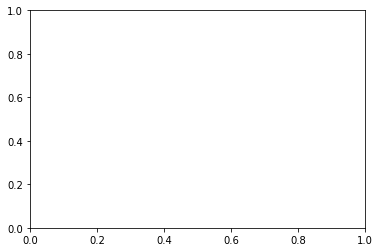

In [6]:
%matplotlib inline
# Plot outputs
plt.scatter(dat_x_test, dat_y_test,  color='black')
plt.plot(dat_x_test, dat_y_pred, color='blue', linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()


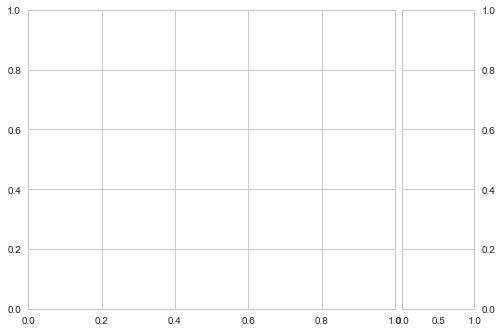

In [7]:
from yellowbrick.regressor import ResidualsPlot
visualizer = ResidualsPlot(mod_01)
